In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import datetime as dt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Eigenportfolio strategy.
In the following we implement *eigenportfolio* strategy. It is based on the work of Avellaneda and Lee of 2008, see https://math.nyu.edu/~avellane/AvellanedaLeeStatArb20090616.pdf. The portfolio is constructed by employing Principal Component Analysis (PCA). We select the principal component corresponding to the best Sharpe ratio to construct our portfolio.

We train our model using S&P500 data from Yahoo! Finance. We compare our portfolio to SPY ETF.

In [2]:
# Get the SP500 tickers.
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace dots by dashes to avoid issues when using yfinace.
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Get the list of tickers. 
symbols_list = sp500['Symbol'].unique().tolist()

# Set start and end dates for the data.
end_date = pd.to_datetime('2018-01-01')

start_date = pd.to_datetime('2010-01-01')

# Download data using yfinace.
asset_prices = yf.download(tickers = symbols_list,
                start = start_date,
                end = end_date)[['Adj Close']]

[*********************100%%**********************]  503 of 503 completed


114 Failed downloads:
['UAL', 'NVDA', 'SBAC', 'AMAT', 'MU', 'TGT', 'RF', 'IRM', 'ES', 'VTR', 'MHK', 'FFIV', 'ODFL', 'PG', 'SHW', 'XEL', 'MTB', 'HSIC', 'NXPI', 'BKR', 'QRVO', 'BR', 'AXON', 'CSCO', 'AVGO', 'MAS', 'GWW', 'STE', 'ACN', 'HUM', 'ILMN', 'ENPH', 'JNPR', 'GOOG', 'CMS', 'LRCX', 'DVN', 'BIO', 'MSFT', 'FITB', 'APD', 'HBAN', 'NI', 'MAR', 'CPT', 'AMCR', 'IFF', 'GS', 'VLTO', 'HII', 'VFC', 'PNW', 'BAC', 'MNST', 'PWR', 'HIG', 'DUK', 'SNA', 'VMC', 'ARE', 'LUV', 'ICE', 'ZTS', 'COO', 'HAS', 'PFG', 'XRAY', 'DG', 'ROST', 'GEHC', 'V', 'DTE', 'COP', 'CFG', 'KMB', 'CAG', 'AJG', 'RTX', 'ZBRA', 'WRK', 'SEE', 'DRI', 'EIX', 'EBAY', 'MSI', 'EQR', 'TJX', 'AXP', 'PKG', 'FDX', 'TSN', 'ESS', 'IEX', 'FAST', 'STX', 'NUE', 'LOW', 'TMO', 'IT', 'FI', 'ANSS', 'FDS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 00:00:00 -> 2018-01-01 00:00:00)')
['CEG', 'DOW', 'VICI', 'OTIS', 'CARR', 'MRNA', 'FOXA', 'CDAY', 'FOX', 'CTVA', 'ABNB', 'KVUE']: Exception("%ticker%: Data doesn't 

In [3]:
# Compute returns and standardise the data. 
asset_returns = asset_prices.pct_change().drop(asset_prices.index[0])
nan_cols = asset_returns.columns[asset_returns.isna().any() == True]
asset_returns.drop(columns = nan_cols, axis = 1, inplace = True)

normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()

# Split data into train and test sets.
train_end = dt.datetime(2016, 1, 1) 

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_train = df_train['Adj Close']

df_raw_test = asset_returns[asset_returns.index > train_end].copy()
df_raw_test = df_raw_test['Adj Close']

print('Train dataset shape:', df_train.shape)
print('Test dataset shape:', df_raw_test.shape)

Train dataset shape: (1509, 346)
Test dataset shape: (503, 346)


Text(0.5, 1.0, 'Empirical Correlation Matrix Heatmap')

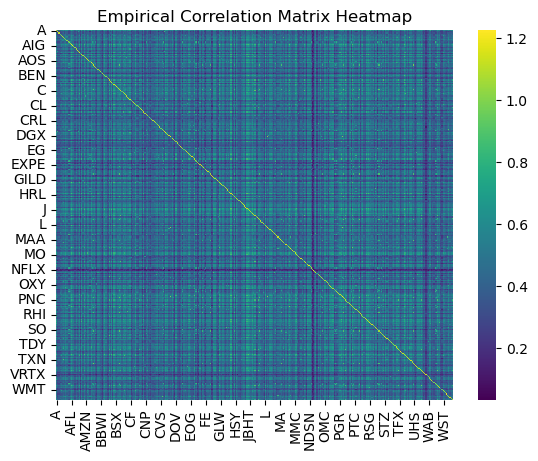

In [4]:
# Compute the empirical correlation matrix for the training data period.
cov = df_train.cov()
cov_heatmap = sns.heatmap(cov, cmap = sns.color_palette("viridis", as_cmap = True))
plt.title('Empirical Correlation Matrix Heatmap')

3 components explain 80.0% of variance.


<BarContainer object of 13 artists>

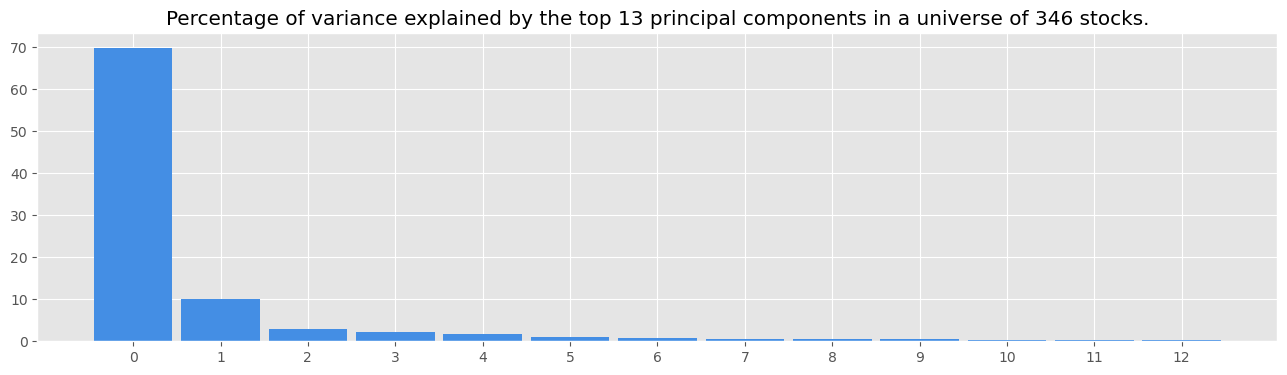

In [5]:
# Compute principal components and get explained variance.
pca = PCA().fit(cov)
principal_components = pca.components_
explained_variance = pca.explained_variance_ratio_

var_threshold = 0.8
n_components = np.where(np.logical_not(np.cumsum(explained_variance) < var_threshold))[0][0] + 1
print(f'{n_components} components explain {100 * var_threshold}% of variance.')

plt.style.use('ggplot')
n_display = n_components + 10
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
x_index = np.arange(len(explained_variance[:n_display]))
ax.set_xticks(x_index)
ax.set_xticklabels(list(range(n_display)))
ax.set_title(f'Percentage of variance explained by the top {n_display} principal components in a universe of {len(df_train.columns)} stocks.')
ax.bar(x_index, explained_variance[:n_display] * 100, width = .9, color = "xkcd:dark sky blue")

In [6]:
def get_eigenportfolio(principal_components, stocks, n = 1, plot = True):
    """
    Calculate and visualize the eigenportfolio based on the principal components.

    Parameters:
        principal_components (pd.DataFrame): A DataFrame of principal components.
        stocks (list): A list of stock names.
        n (int, optional): The index of the principal component to use. Defaults to 1.
        plot (bool, optional): Whether to plot the eigenportfolio. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the eigenportfolio weights.
    """
    eigen_weights = principal_components[:, n]
    
    # Check if weights are normalized.
    if np.sum(eigen_weights) != 1.:
        eigen_weights = eigen_weights / np.sum(eigen_weights)

    # Create an eigenportfolio DataFrame with weights.
    eigenportfolio_df = pd.DataFrame(data={'Portfolio weights': eigen_weights * 100}, index = stocks)
    eigenportfolio_df.sort_values(by=['Portfolio weights'], ascending = False, inplace = True)

    if plot:
        # Plot the eigenportfolio weights.
        eigenportfolio_df.plot(
            title = f'Eigenportfolio Weights for the Principal Component Indexed {n}.',
            figsize = (16, 4),
            xticks = range(0, len(stocks), 10),
            rot = 65,
            linewidth = 2,
            color = "xkcd:dark sky blue"
        )

    return eigenportfolio_df

,ROK,NSC,LEN,ZION,KO,ORLY,HPQ,BRO,MPWR,PM,...,VRTX,NKE,MS,HD,GL,JPM,GPC,PNR,K,PCAR
Portfolio weights,40.975964,39.11323,37.908045,36.980176,31.626147,31.369171,31.021513,28.672549,27.927245,27.476986,...,-29.833933,-30.913357,-31.176523,-31.46275,-31.568638,-34.21689,-38.335718,-43.907343,-44.841456,-51.905273


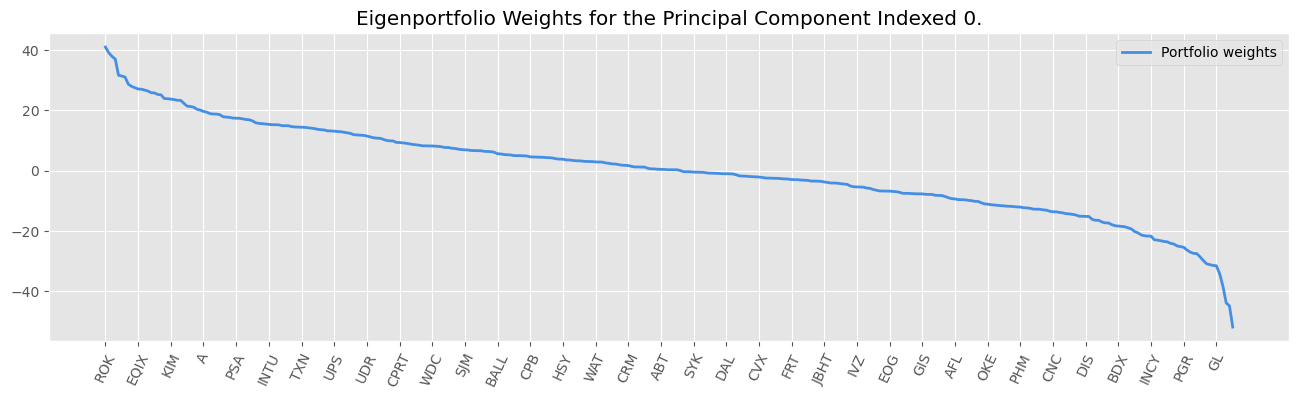

In [7]:
eigenportfolio0 = get_eigenportfolio(principal_components, df_train.columns, 0)
eigenportfolio0.T

,ALB,AEP,ADP,AES,AMD,ADM,BK,BXP,APH,KIM,...,BIIB,ADBE,FE,LEN,PFE,COST,PHM,AKAM,MRK,GD
Portfolio weights,33.730482,29.161256,23.023429,22.035785,20.252169,18.435497,15.236963,14.582548,14.54321,13.61912,...,-12.172712,-12.263895,-12.404754,-12.47246,-12.552081,-13.740642,-14.171747,-15.380195,-17.506402,-17.598232


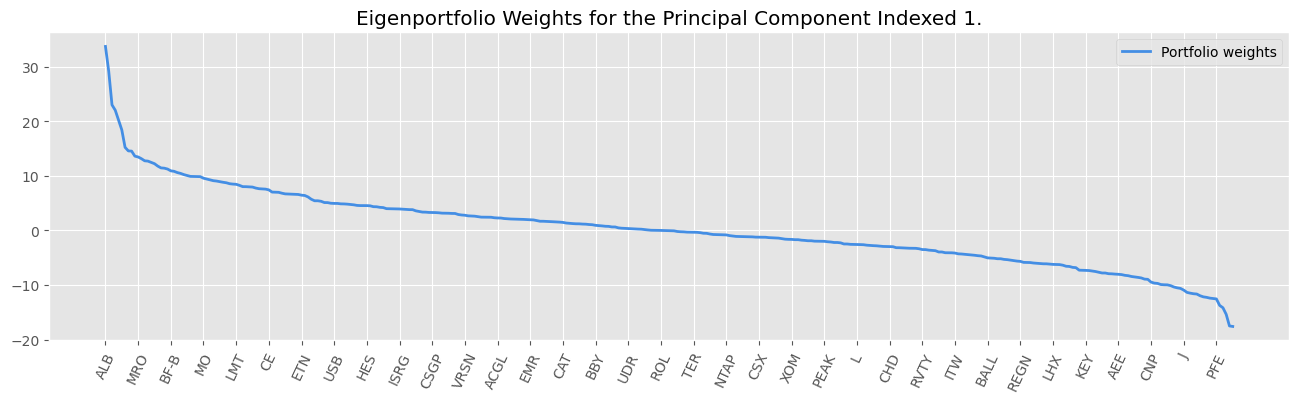

In [8]:
eigenportfolio1 = get_eigenportfolio(principal_components, df_train.columns, 1)
eigenportfolio1.T

In [9]:
def get_portfolio_returns(portfolio_weights, stock_returns):
    """
    Calculate portfolio returns based on given portfolio weights and stock returns.

    Parameters:
        portfolio_weights (pd.Series): A pandas Series containing the weights of assets in the portfolio.
        stock_returns (pd.DataFrame): A DataFrame containing stock returns with dates as the index.

    Returns:
        pd.DataFrame: A DataFrame with a column named 'Portfolio returns' representing the calculated portfolio returns.
    """
    portfolio_returns = pd.DataFrame()

    # Calculate portfolio returns for each row (date) in the stock_returns DataFrame.
    portfolio_returns['Portfolio returns'] = stock_returns.loc[:, portfolio_weights.index].apply(
        lambda x: x @ portfolio_weights.to_numpy().squeeze() / 100, axis = 1)

    return portfolio_returns

def sharpe_ratio(portfolio_returns, risk_free_rate = 0, periods_per_year = 252):
    """
    Calculate the annualized return, annualized volatility, and Sharpe ratio.

    Parameters:
    - portfolio_returns (pd.Series or array-like): Time series of returns for a single portfolio.
    - risk_free_rate (float): The annual risk-free rate (default is 0.0).
    - periods_per_year (int): Number of periods per year (default is 252 for daily data).

    Returns:
    - tuple of three floats: Annualized return, annualized volatility, and Sharpe ratio.
    """
    
    # Calculate the number of years from the length of the time series.
    n_years = len(portfolio_returns) / periods_per_year

    # Calculate the annualized return using the geometric mean.
    annualized_return = np.exp(np.log(1 + portfolio_returns).sum() / n_years) - 1

    # Calculate the annualized volatility
    annualized_volatility = np.std(portfolio_returns, ddof=1) * np.sqrt(periods_per_year)

    # Calculate the Sharpe ratio using the risk-free rate.
    excess_returns = portfolio_returns - risk_free_rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return annualized_return, annualized_volatility, sharpe_ratio

In [10]:
eigenportfolio_returns = get_portfolio_returns(eigenportfolio0, df_raw_test)
an_return, volatility, sharpe = sharpe_ratio(eigenportfolio_returns)
print(f'First Eigenportfolio:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

eigenportfolio_returns = get_portfolio_returns(eigenportfolio1, df_raw_test)
an_return, volatility, sharpe = sharpe_ratio(eigenportfolio_returns)
print(f'Second Eigenportfolio:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

First Eigenportfolio:
Return = 30.11%
Volatility = 75.10%
Sharpe = 0.40

Second Eigenportfolio:
Return = 31.41%
Volatility = 35.81%
Sharpe = 0.88



,Portfolio Return,Volatility,Sharpe Ratio
94,0.509269,0.225737,2.078830
55,0.802600,0.388060,1.965157
8,0.705913,0.342628,1.943547
97,0.463466,0.225632,1.876796
41,0.487562,0.255468,1.751931
...,...,...,...
6,-0.109627,0.207933,-0.719592
73,-0.507764,0.752167,-0.728248
90,-0.209225,0.326802,-0.762618
38,-0.158198,0.238429,-0.831267


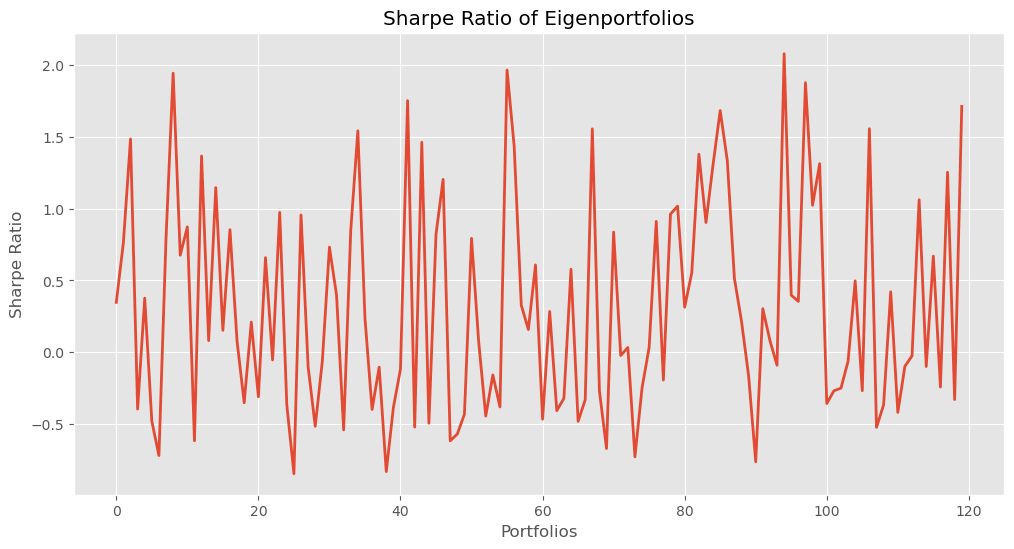

In [11]:
def compute_sharpes(principal_components, stock_returns, plot = True, risk_free_rate = 0.04):
    """
    Calculate Sharpe ratios for eigenportfolios generated from principal component analysis.

    Arguments:
    principal_components (pd.DataFrame): The principal components obtained from PCA.
    stock_returns (pd.DataFrame): A DataFrame containing stock returns.
    plot (bool, optional): If True, a plot of Sharpe ratios will be generated. Default is True.
    risk_free_rate (float, optional): The risk-free rate used in Sharpe ratio calculations. Default is 0.04.

    Returns:
    pd.DataFrame: A DataFrame containing portfolio statistics including Portfolio Return, Volatility, and Sharpe Ratio.
    
    If 'plot' is set to True, a plot of Sharpe ratios is generated.
    """
    # Initialize NumPy arrays for returns, volatilities and Sharpe ratios.
    annualized_returns = np.array([0.] * principal_components.shape[1])
    sharpes = np.array([0.] * principal_components.shape[1])
    annualized_volatility = np.array([0.] * principal_components.shape[1])
    
    # Compute returns, volatilities and Sharpe ratios for each portfolio.
    for i in range(principal_components.shape[1]):
        eigenportfolio = get_eigenportfolio(principal_components, stock_returns.columns, n = i, plot = False)
        portfolio_returns = get_portfolio_returns(eigenportfolio, stock_returns)
        annualized_returns[i], annualized_volatility[i], sharpes[i] = sharpe_ratio(portfolio_returns, risk_free_rate)
    
    # Create a DataFrame with the returns, volatilities and Sharpe ratios.  Sort by the latter.
    portfoloio_stats_df = pd.DataFrame(data = {'Portfolio Return': annualized_returns, 
                                               'Volatility': annualized_volatility, 
                                               'Sharpe Ratio': sharpes}
                                      ).dropna()
    portfoloio_stats_df.sort_values(by = ['Sharpe Ratio'], ascending = False, inplace = True)
    
    if plot:
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)
        ax.plot(sharpes, linewidth = 2)
        ax.set_title('Sharpe Ratio of Eigenportfolios')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_xlabel('Portfolios')
    
    return portfoloio_stats_df

portfolois_stats = compute_sharpes(principal_components[:, :120], df_raw_test)
portfolois_stats

In [12]:
# Download SPY data using yfinance.
spy = yf.download(tickers = 'SPY',
                start = start_date,
                end = end_date)

# Compute SPY returns.
spy_returns = spy.pct_change().drop(spy.index[0]).rename({'Adj Close':'SPY Buy&Hold'}, axis = 1)['SPY Buy&Hold']

[*********************100%%**********************]  1 of 1 completed


Correlation of Eigenportfolio and SPY:  0.647773

Eigenportfolio:
Return = 50.93%
Volatility = 22.57%
Sharpe = 2.26

SPY:
Return = 13.61%
Volatility = 14.63%
Sharpe = 0.93



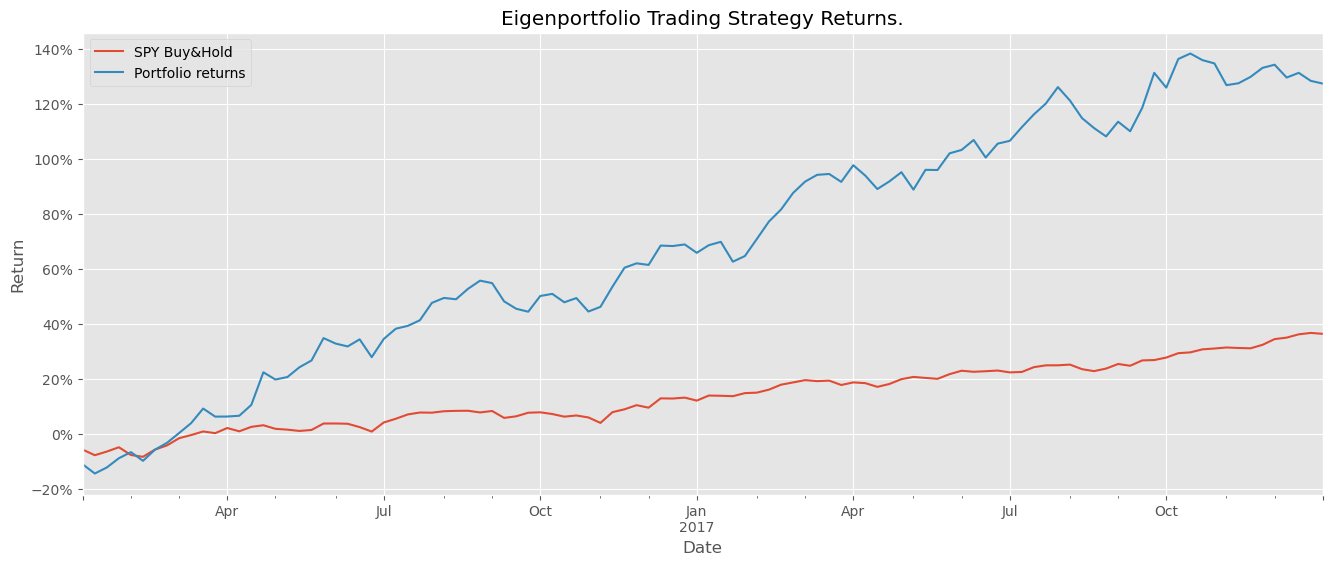

In [13]:
# Compute returns for the eigenportfolio with the highest Sharpe ratio and compare with SPY returns.
eigenportfolio = get_eigenportfolio(principal_components, df_raw_test.columns, n = portfolois_stats.index[0], plot = False)
portfolio_returns = get_portfolio_returns(eigenportfolio, df_raw_test)

df_returns = pd.DataFrame(data = spy_returns).merge(portfolio_returns[portfolio_returns.index[0]:], left_index = True, right_index = True)

print(f'Correlation of Eigenportfolio and SPY: {df_returns.corr().iloc[0,1]: 2f}\n')

an_return, volatility, sharpe = sharpe_ratio(portfolio_returns)
print(f'Eigenportfolio:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

an_return, volatility, sharpe = sharpe_ratio(spy_returns)
print(f'SPY:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

# Plot cumulative returns.
portfolio_cumulative_return = np.cumprod(df_returns + 1) - 1
portfolio_cumulative_return.resample('W').last().plot(figsize = (16,6))

plt.style.use('ggplot')
plt.title('Eigenportfolio Trading Strategy Returns.')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

Correlation of combined Eigenportfolio and SPY:  0.610376

Combined Eigenportfolio:
Return = 66.03%
Volatility = 18.97%
Sharpe = 3.48

SPY:
Return = 13.61%
Volatility = 14.63%
Sharpe = 0.93



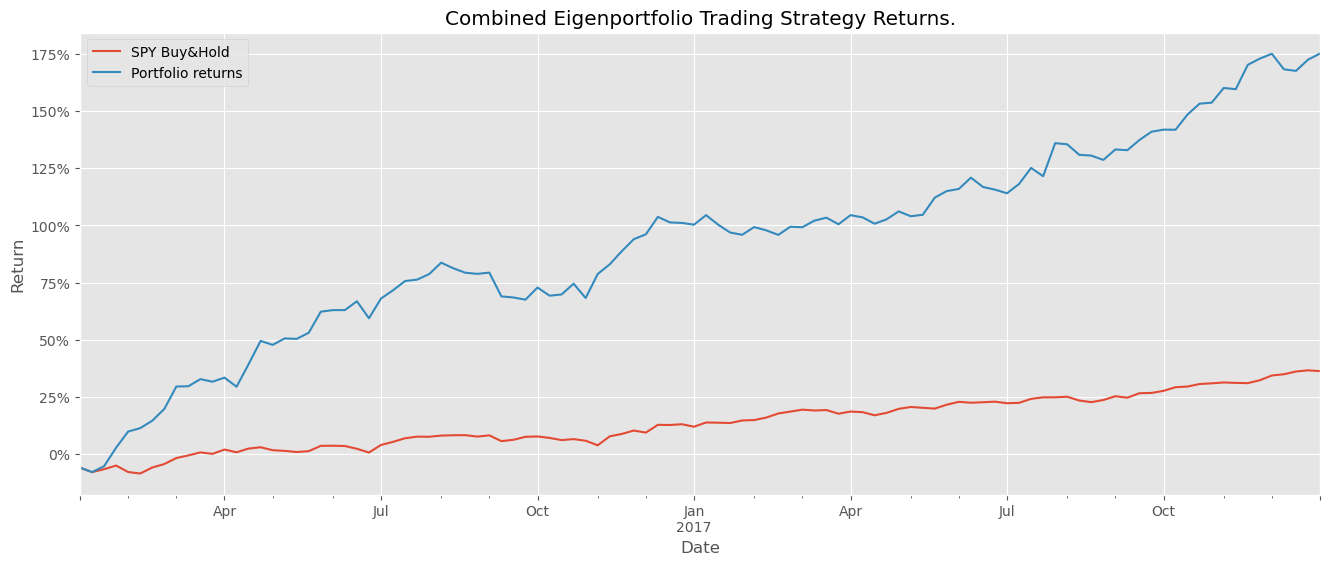

In [14]:
# Compute returns for a portfolio of a combination eigenportfolios taken with euqal weights and compare with SPY returns.
portfolio_returns = 0
n_eigenportfolios = 4
for i in range(n_eigenportfolios):
    
    eigenportfolio = get_eigenportfolio(principal_components, df_raw_test.columns, n = portfolois_stats.index[i], plot = False)
    portfolio_returns += get_portfolio_returns(eigenportfolio, df_raw_test) / n_eigenportfolios

df_returns = pd.DataFrame(data = spy_returns).merge(portfolio_returns[portfolio_returns.index[0]:], left_index = True, right_index = True)

print(f'Correlation of combined Eigenportfolio and SPY: {df_returns.corr().iloc[0,1]: 2f}\n')

an_return, volatility, sharpe = sharpe_ratio(portfolio_returns)
print(f'Combined Eigenportfolio:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

an_return, volatility, sharpe = sharpe_ratio(spy_returns)
print(f'SPY:\nReturn = {float(an_return) * 100:.2f}%\nVolatility = {float(volatility) * 100:.2f}%\nSharpe = {float(sharpe):.2f}\n')

# Plot cumulative returns.
portfolio_cumulative_return = np.cumprod(df_returns + 1) - 1
portfolio_cumulative_return.resample('W').last().plot(figsize = (16,6))

plt.style.use('ggplot')
plt.title('Combined Eigenportfolio Trading Strategy Returns.')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()